In [1]:
import os

os.getcwd()

# os.chdir('/hpcnfs/techunits/imaging/work/ATTEND/achiodin/image_registration/current')
os.chdir('/Volumes/techunits/imaging/work/ATTEND/achiodin/image_registration/current')

import matplotlib.pyplot as plt
import numpy as np
from utils.load_registration_images import load_registration_images

# from utils.pickle_utils import save_to_pickle
# from utils.pickle_utils import load_pickle
from utils.image_cropping import crop_2d_array
from utils.image_cropping import crop_2d_array_grid
from utils.image_stitching import stitch_registered_crops

In [2]:
import itertools

def remove_crops_overlap(crops: list, overlap: int, axis: int = 0):
    """
    Remove overlapping region from adjacent crops.
    Arguments:
        crops (list): list structured as follows:
                  [((0, 0, 0), [...]),
                   ((...), [...])        
                   ((n, m, c), [...])] 
                   where the first element of the inner tuple is the row index, the second is
                   the column index, and the third is the image channel. 
                   The second element of each tuple is a 2D numpy array. 
        overlap (int): overlap between each section
        axis (int): axis along which to remove the overlap.
                    0 to remove along rows
                    1 to remove along columns
    Output:
        crops_no_overlap (list): list with the same structure as crops. 
    """

    overlap_half_left = overlap // 2
    overlap_half_right = overlap - overlap_half_left
    crops_no_overlap = []

    # Sort crops by row and then by column
    crops = sorted(crops, key=lambda x: (x[0][0], x[0][1]))

    for idx, crop in crops:
        start_row, end_row, start_col, end_col = 0, crop.shape[0], 0, crop.shape[1]

        # Handle row overlap
        if axis == 0:
            if idx[0] != 0:
                start_row += overlap_half_left
            if idx[0] != max(idx[0] for idx, _ in crops):
                end_row -= overlap_half_right

        # Handle column overlap
        if axis == 1:
            if idx[1] != 0:
                start_col += overlap_half_left
            if idx[1] != max(idx[1] for idx, _ in crops):
                end_col -= overlap_half_right

        # Extract the crop area without overlap
        crop_no_overlap = crop[start_row:end_row, start_col:end_col]

        # Append the non-overlapping crop to the list
        crops_no_overlap.append((idx, crop_no_overlap))
    
    return crops_no_overlap


def get_stitching_positions(crops):
    # Determine the number of crop rows and columns
    n_crop_rows = np.max([element[0][0] for element in crops]) + 2
    n_crop_cols = np.max([element[0][1] for element in crops]) + 2

    # Calculate row stitching positions
    sorted_crops = sorted(crops, key=lambda x: x[0][1])
    if n_crop_rows - 1 > 1:
        crops_rows = [crop.shape[0] for idx, crop in sorted_crops][:n_crop_rows - 2]
    else:
        crops_rows = [crop.shape[0] for idx, crop in sorted_crops][:n_crop_rows - 1]

    crops_rows = np.insert(crops_rows, 0, 0)
    stitching_positions_h = np.cumsum(crops_rows)

    # Calculate column stitching positions
    sorted_crops = sorted(crops, key=lambda x: x[0][0])
    if n_crop_cols - 1 > 1:
        crops_cols = [crop.shape[1] for idx, crop in sorted_crops][:n_crop_cols - 2]
    else:
        crops_cols = [crop.shape[1] for idx, crop in sorted_crops][:n_crop_cols - 1]

    crops_cols = np.insert(crops_cols, 0, 0)
    stitching_positions_v = np.cumsum(crops_cols)

    # Generate stitching positions
    stitching_positions = list(itertools.product(stitching_positions_h, stitching_positions_v))

    return stitching_positions


def stitch_images_variable_size(rectangles, positions):
    """
    Stitches an array of rectangular images of variable sizes into a single large image.

    Parameters:
    rectangles (list of np.array): List of rectangular images to be stitched.
    positions (list of tuple): List of (row, col) positions where each rectangle will be placed in the final image.

    Returns:
    np.array: The stitched image.
    """
    # Determine the size of the final stitched image
    max_height = 0
    max_width = 0
    
    for rectangle, (row, col) in zip(rectangles, positions):
        height, width = rectangle.shape[:2]
        max_height = max(max_height, row + height)
        max_width = max(max_width, col + width)
    
    # Initialize an empty array for the stitched image
    stitched_image = np.zeros((max_height, max_width), dtype=rectangles[0].dtype)
    
    for rectangle, (row, col) in zip(rectangles, positions):
        height, width = rectangle.shape[:2]
        stitched_image[row:row + height, col:col + width] = rectangle
    
    return stitched_image


def stitch_images(crops):
    stitching_positions = get_stitching_positions(crops)
    stitched = stitch_images_variable_size([crop for idx, crop in crops], stitching_positions)

    return stitched


def stitch_registered_crops(images, overlap_v, overlap_h):
    # Remove overlap along columns
    crops_no_overlap = remove_crops_overlap(crops=images, overlap=overlap_v, axis=1) 
    
    # Remove overlap along rows
    crops_no_overlap = remove_crops_overlap(crops=crops_no_overlap, overlap=overlap_h, axis=0) 

    stitched = stitch_images(crops_no_overlap)

    return stitched

In [3]:
def add_borders(arr, m, n, left=None, top=None):
    rows, cols = arr.shape
    
    # Handle column modifications
    if left is not None:
        zero_columns = np.zeros((rows, n))
        if left:
            # Prepend n zero columns
            arr = np.hstack((zero_columns, arr))
            # Remove the last n columns
            arr = arr[:, :-n]
        else:
            # Append n zero columns
            arr = np.hstack((arr, zero_columns))
            # Remove the first n columns
            arr = arr[:, n:]
    
    # Handle row modifications
    if top is not None:
        zero_rows = np.zeros((m, cols))
        if top:
            # Prepend m zero rows
            arr = np.vstack((zero_rows, arr))
            # Remove the last m rows
            arr = arr[:-m, :]
        else:
            # Append m zero rows
            arr = np.vstack((arr, zero_rows))
            # Remove the first m rows
            arr = arr[m:, :]

    return arr


## LOAD DATA

In [4]:
# imgs_dir = '/hpcnfs/techunits/imaging/work/ATTEND/crops_Zhan_images'
imgs_dir = '/Volumes/techunits/imaging/work/ATTEND/crops_Zhan_images'

fixed_image_idx = 0
moving_image_idx = 1
crop_size = 2048
shape = (crop_size, crop_size, 3)

reference_image, moving_image = load_registration_images(imgs_dir, 1, 0, crop_size, as_gray=False)

Target image path: /Volumes/techunits/imaging/work/ATTEND/crops_Zhan_images/15-13901_DAPI_FOXP3_PDL1_2.ome.tiff - 15-13901_DAPI_FOXP3_PDL1_2.nd2 (series 1) (1, x=9432, y=22853, w=2048, h=2048).ome.tif '
'              Moving image path: /Volumes/techunits/imaging/work/ATTEND/crops_Zhan_images/15-13901_DAPI_CD8_CD4.ome.tiff - 15-13901_DAPI_CD8_CD4.nd2 (series 1) (1, x=8704, y=21655, w=2048, h=2048).ome.tif


In [5]:
strip_width_v = int(np.ceil(reference_image.shape[1] * 0.3))
overlap_v = int(np.ceil(strip_width_v * 0.2))
strip_width_h = int(np.ceil(reference_image.shape[0] * 0.4))
overlap_h = int(np.ceil(strip_width_h * 0.2))

print(strip_width_v, strip_width_h, overlap_v, overlap_h)

615 820 123 164


In [17]:
ref_crops = crop_2d_array_grid(reference_image, strip_width_v, strip_width_h, overlap_v, overlap_h)

ref_crops_dapi = [(idx, crop[:, :, 2]) for idx, crop in ref_crops]

In [105]:
# Example usage
m = 10
n = 10
left = False
top = False


crops_with_borders =[]
for idx, crop in ref_crops_dapi:
    crops_with_borders.append((idx, add_borders(crop, m, n, left, top)))

stitched = stitch_registered_crops(crops_with_borders, overlap_h=overlap_h, overlap_v=overlap_v)

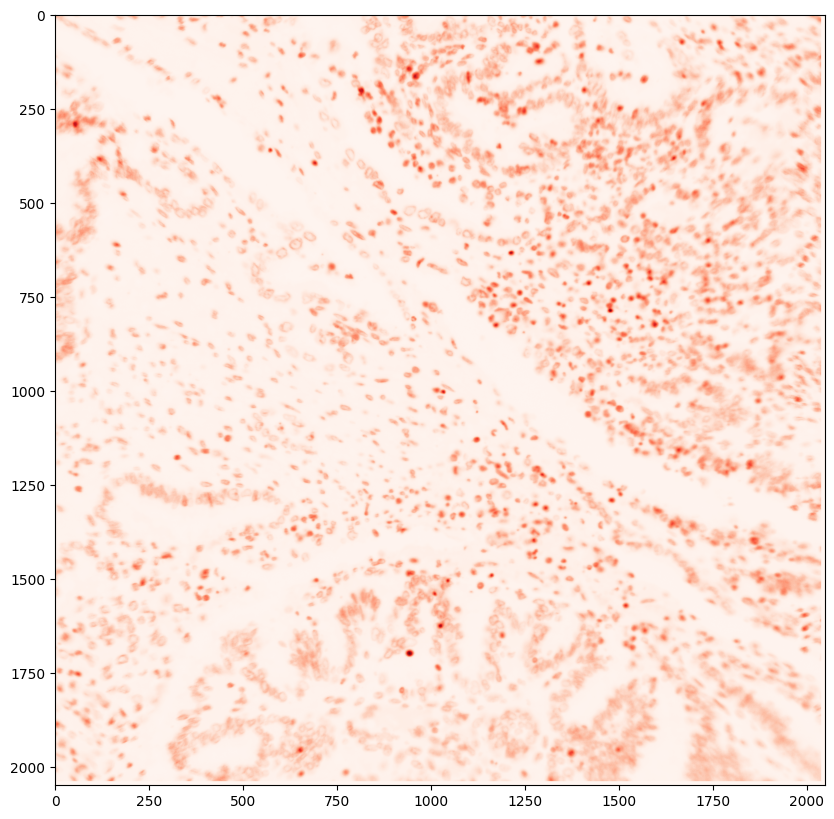

(2048, 2048)
820 615 164 123


In [112]:
# Display the stitched image
plt.figure(figsize=(10, 10))
plt.imshow(stitched, cmap='Reds')
# plt.axis('off')
plt.show()

print(stitched.shape)
print(strip_width_h, strip_width_v, overlap_h, overlap_v)

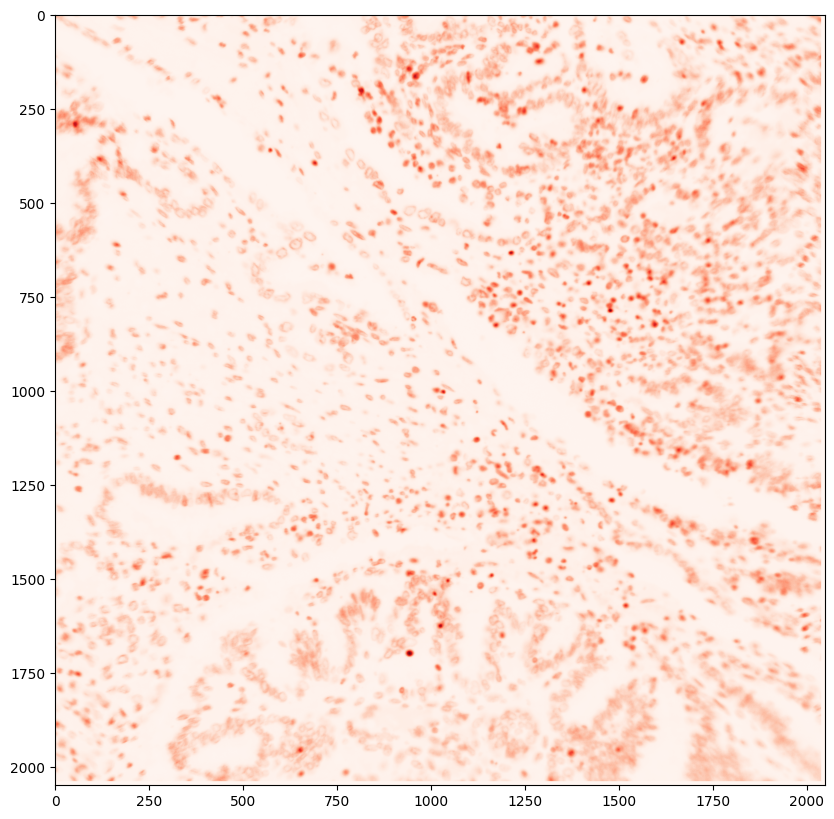

(2048, 2048)

In [113]:
target = add_borders(reference_image[:, :, 2], m=m, n=n, left=left, top=top)

# Display the stitched image
plt.figure(figsize=(10, 10))
plt.imshow(target, cmap='Reds')
plt.show()
target.shape

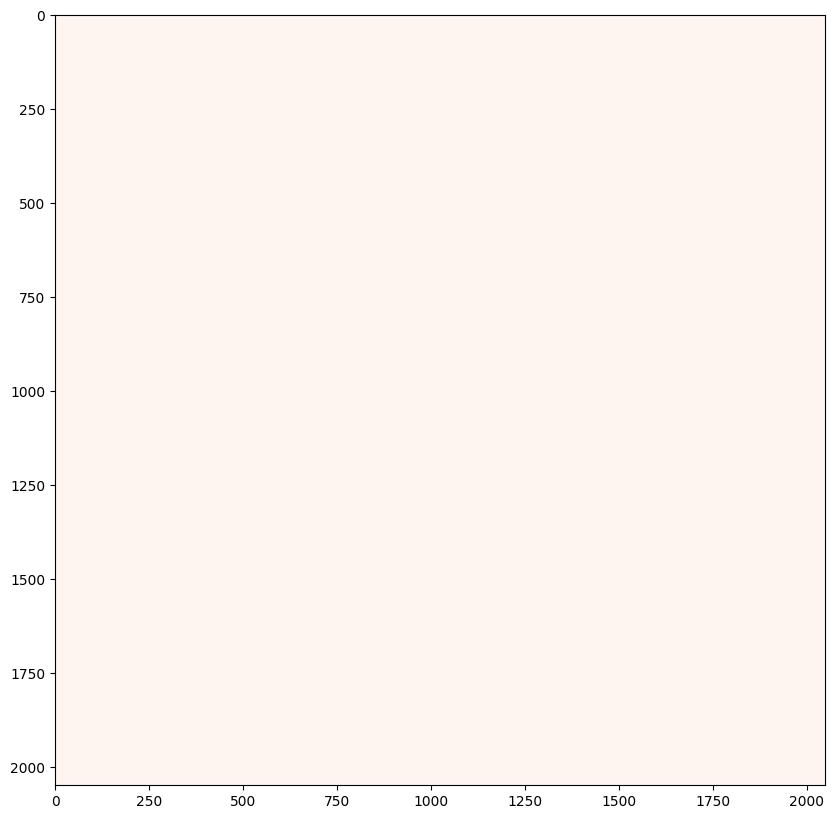

In [114]:
check = stitched_flipped == target

# Display the stitched image
plt.figure(figsize=(10, 10))
plt.imshow(check, cmap='Reds')
plt.show()